In [1]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=55a3833d9c02c67226d34e5222852fec1e78bd7724f42890693c97980ab40576
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

In [3]:
X_train = np.load('/kaggle/input/pretrained-unlabelled/X_pretrain.npy')

In [4]:
X_train.shape

(40000, 125, 125, 8)

In [5]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


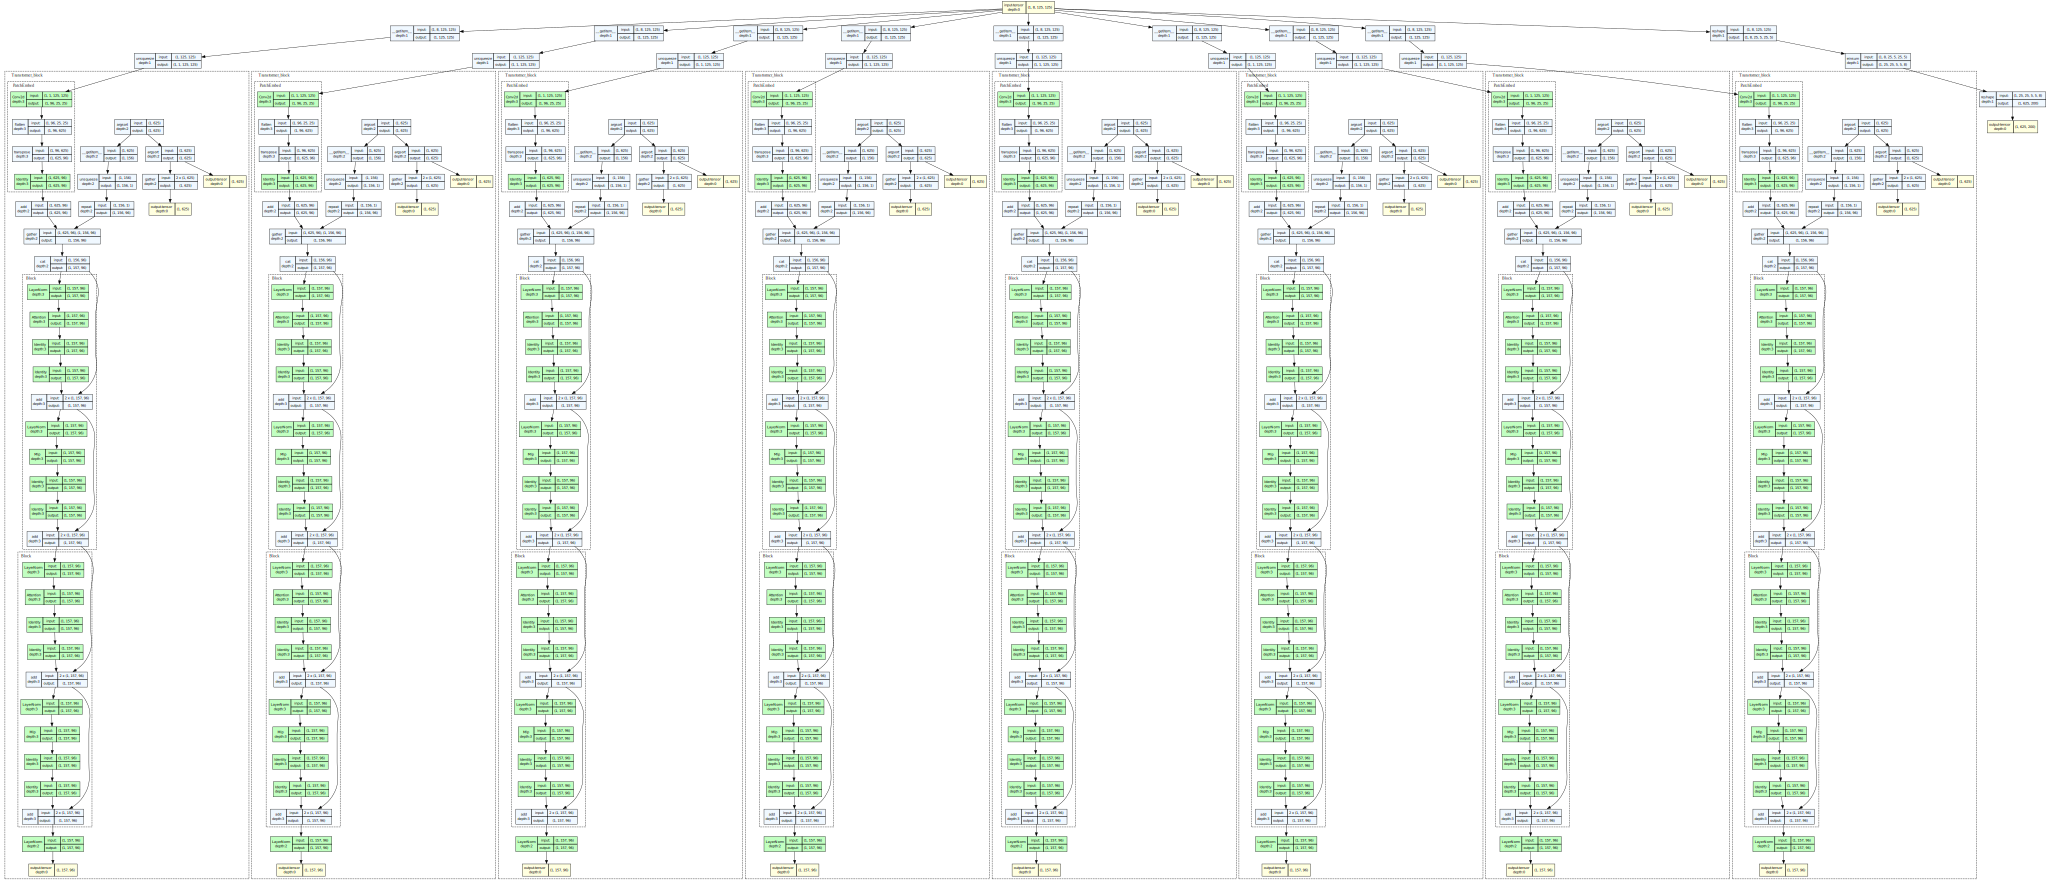

In [6]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
#         imgs = self.patchify(x)

        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)

        
    def forward(self, x):
        encoded_tensor = []
        masks = []
        ids = []
        
        for i in range(8):
            img = x[:,i,:,:].unsqueeze(1)
            op, mask, ids_restore = self.block(img)
            encoded_tensor.append(op)
            masks.append(mask)
            ids.append(ids_restore)
            
        img = self.block.patchify(x)
            
        return encoded_tensor, masks, ids, img
    
import torchvision
from torchview import draw_graph
from torchviz import make_dot
encoder = Encoder(
    img_size=125, patch_size=5, in_chans = 1,embed_dim=96, depth=2, num_heads=8,
    mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [7]:
class Decoder_transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 8, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x =   # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
             embed_dim=1024, depth=24, num_heads=16,
             decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Decoder_transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                                                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                                                 decoder_embed_dim=decoder_embed_dim, decoder_depth=decoder_depth, decoder_num_heads=decoder_num_heads,
                                                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, 96))
        
    def forward(self, x, ids):
        
        op = []
        cls_token = []
        for i in range(len(x)):
#             print(x[i].shape)
            mask_tokens = self.mask_token.repeat(x[i].shape[0], ids[i].shape[1] + 1 - x[i].shape[1], 1)
            x_ = torch.cat([x[i][:, 1:, :], mask_tokens], dim=1)  # no cls token
            cls_token.append(x[i][:,:1,:])
            x_ = torch.gather(x_, dim=1, index=ids[i].unsqueeze(-1).repeat(1, 1, x[i].shape[2]))  # unshuffle
            op.append(x_)
    
        op = torch.cat(op, axis = 2)
        cls_token = torch.cat(cls_token, axis = 2)
#         print(op.shape)
        op = torch.cat([cls_token, op], dim=1)
#         print(op.shape)
        op = self.block(op)
        return op

In [8]:
  
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, img = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return pred, mask, img
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=96, depth=6, num_heads=8,in_chans = 1,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=6, num_heads=8,in_chans = 1,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)

In [9]:
# from timm.models.vision_transformer import PatchEmbed, Block??

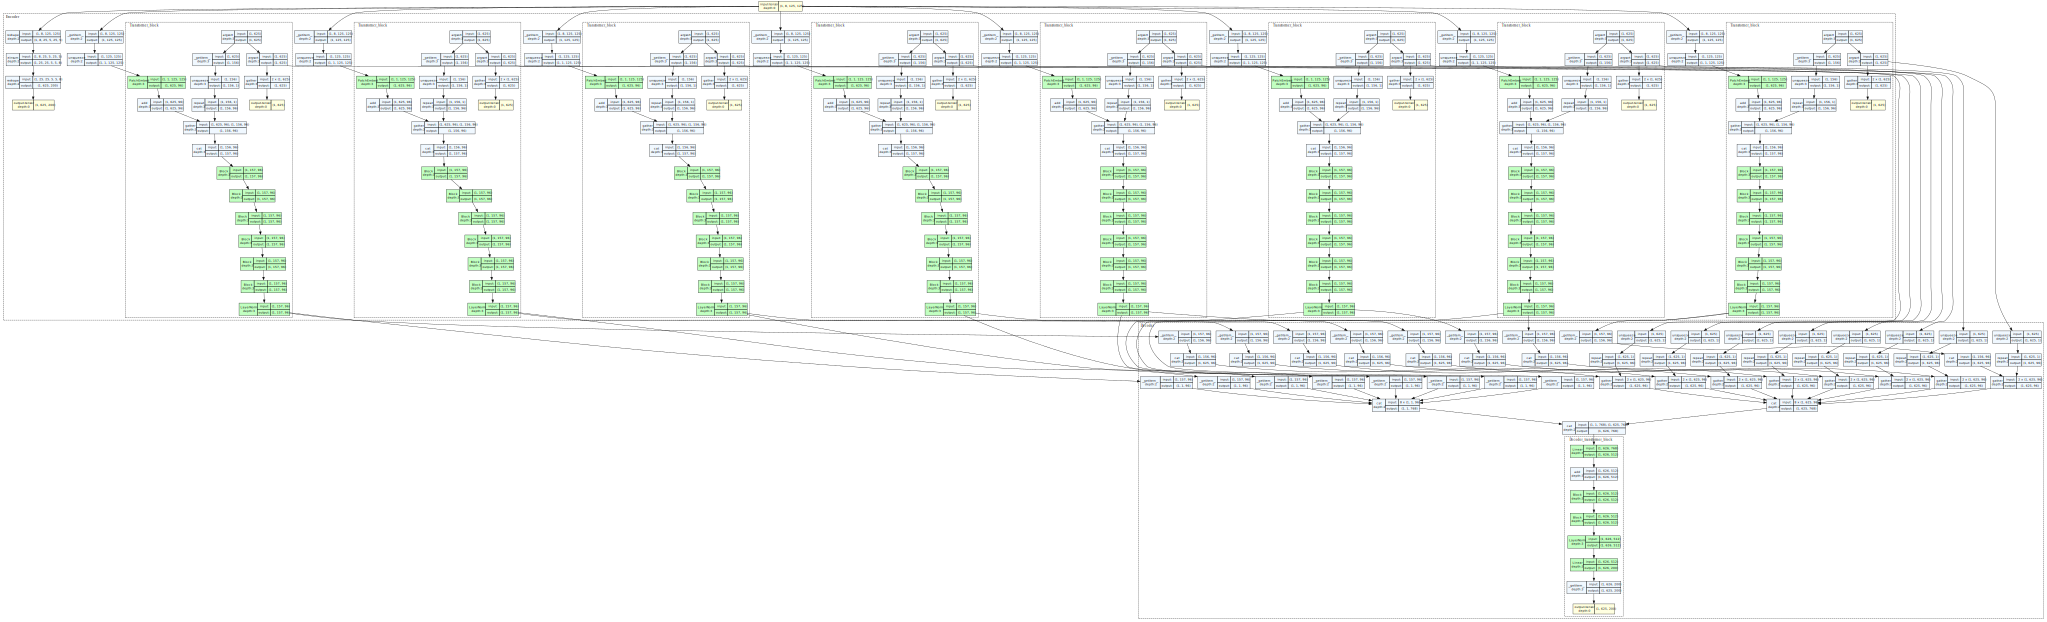

In [10]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [11]:
x = torch.rand((1,8,125,125)).to('cuda')
x, mask, imgs = model(x)
# len(mask[0])
mask[0].shape

torch.Size([1, 625])

In [12]:
import torchvision
# from torchview import draw_graph
# model_graph = draw_graph(model, input_size=(16,8,125,125), expand_nested=True)
# model_graph.visual_graph      

In [13]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
#         self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx])
        
        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X_train, transform = transform)
sample = dataset.__getitem__(0)
print((sample['img']).shape)

torch.Size([8, 125, 125])


In [14]:
# # !pip install torchviz
# sample = dataset.__getitem__(0)
# print((sample['img']).shape)

# img = sample['img'].permute(1,2,0)
# img = img.cpu().detach().numpy()

# import matplotlib.pyplot as plt
# for i in range(8):
#     plt.imshow(img[:,:,i])
#     plt.show()

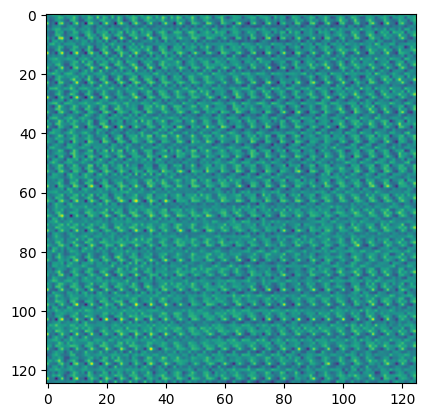

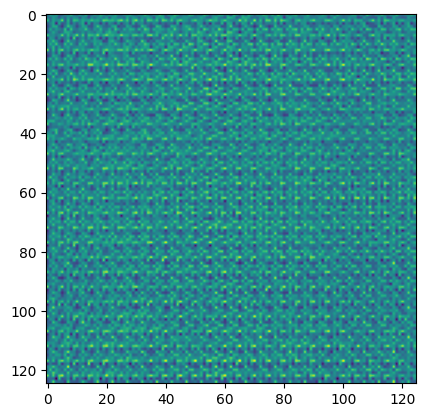

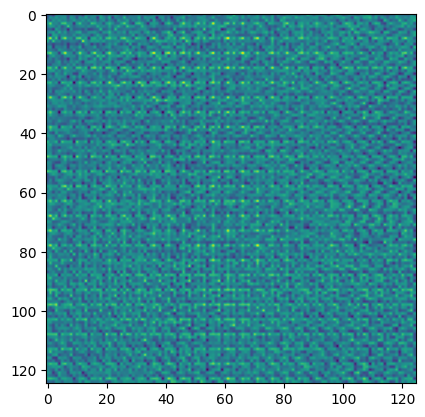

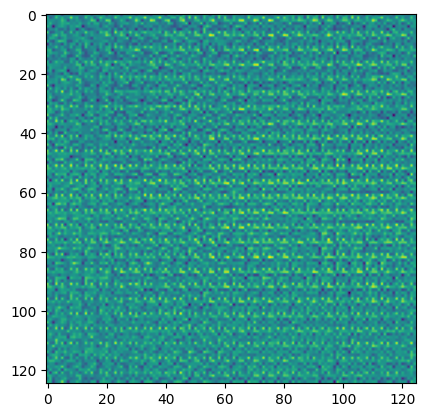

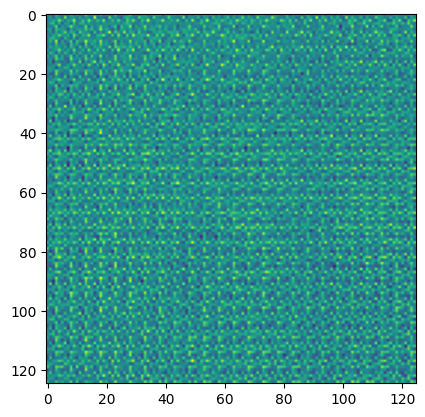

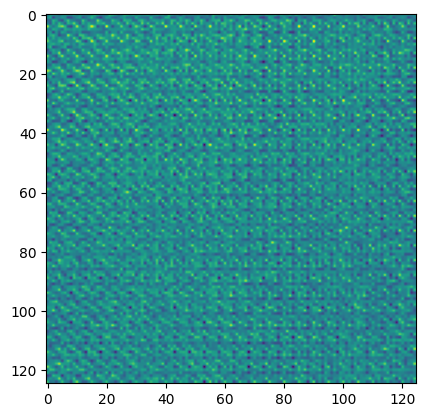

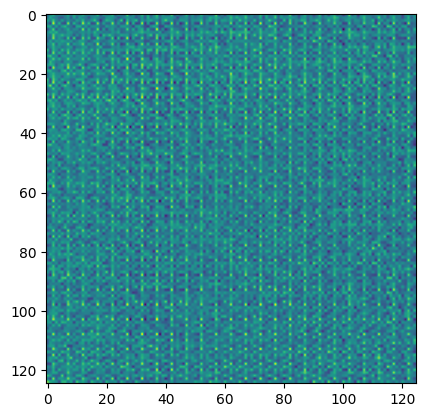

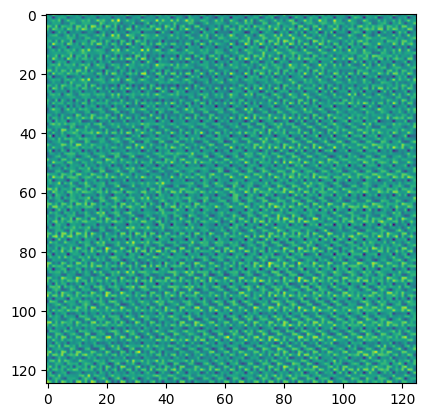

In [15]:
pred, mask, imgs = model(sample['img'].unsqueeze(0).to('cuda'))

pred.shape

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 8, H, W)
    """
    p = 5
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
    return imgs

# pred = pred.reshape((125,125,8))
pred = unpatchify(pred)
pred.shape
pred = pred.reshape((8, 125, 125))
pred.shape

img = pred.permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

In [16]:
# sample['img'].max()

In [17]:
# def custom_loss(imgs, pred):
#     """
#     imgs: [N, 8, H, W]
#     pred: [N, L, p*p*8]
#     mask: [N, L], 0 is keep, 1 is remove, 
#     """
    
#     target = imgs
#     loss = (pred - target) ** 2
#     print(img.shape)

#     print(pred.shape)

#     loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
#     print(loss.shape)

# #     loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
#     return loss

# img = torch.rand((1,625, 200))
# pred = torch.rand((1,625, 200))
# loss = custom_loss(img, pred)
# # print(img)
# # print(pred)
# # print(loss)

In [18]:
# mask[0]

In [19]:
# def custom_loss(imgs, pred, mask):
#     """
#     imgs: [N, 8, H, W]
#     pred: [N, L, p*p*8]
#     mask: [N, L], 0 is keep, 1 is remove, 
#     """
#     imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2]//8))
# #     print(imgs.shape)
#     pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2]//8))
# #     print(pred.shape)
    
# #     loss = np.zeros(((imgs.shape[0], imgs.shape[1], imgs.shape[2])))
#     L = []
# #     print(loss.shape)
#     for i in range(8):
#         l = ((pred[:, : ,i, :] - imgs[:, : ,i, :])**2).unsqueeze(axis = 2).mean(axis = -1)
#         print(l.shape)
# #         print(loss[:, : ,i:i+1,:].shape)
#         loss = (l*np.array(mask[i].detach().cpu())).sum()
#         L.append((loss/mask[i].sum()).detach().cpu())
        
#     return np.array(L).mean()

# img = torch.rand((1,625, 200))
# pred = torch.rand((1,625, 200))
# loss = custom_loss(img, pred, mask)
# print(loss)
import numpy as np
import torch

def custom_loss(imgs, pred, mask):
    imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], 8, imgs.shape[2]//8))
    pred = pred.reshape((pred.shape[0], pred.shape[1], 8, pred.shape[2]//8))


    L = 0
    for i in range(len(mask)):
        l = ((pred[:, : ,i, :] - imgs[:, : ,i, :])**2).unsqueeze(axis = 2).mean(axis = -1)
#         print(l.shape)
        # Move the mask tensor to the CPU before converting it to a NumPy array
        mask_cpu = mask[i].unsqueeze(axis = -1)
        loss = (l * mask_cpu).sum()
        L+=((loss / mask_cpu.sum()))
    
    return L/8


In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# def channel_wise_visualization(original_image, reconstructed_image):
#     """
#     Visualize each channel of the original and reconstructed images separately.
    
#     Args:
#         original_image (numpy.ndarray): Original image with shape (height, width, channels).
#         reconstructed_image (numpy.ndarray): Reconstructed image with shape (height, width, channels).
#     """
#     original_image = original_image.permute(2,0,1).detach().cpu().numpy()  # Rescale back to original range
#     reconstructed_image = reconstructed_image.permute(2,0,1).detach().cpu().numpy()  # Rescale back to original range
    
#     num_channels = 8
    
#     fig, axs = plt.subplots(2, num_channels, figsize=(15, 5))
    
#     for i in range(num_channels):
#         axs[0, i].imshow(original_image[:, :, i])
#         axs[0, i].set_title(f'Original Channel {i+1}')
#         axs[0, i].axis('off')
        
#         axs[1, i].imshow(reconstructed_image[:, :, i])
#         axs[1, i].set_title(f'Reconstructed  {i+1}')
#         axs[1, i].axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
# # original_image = np.random.rand(128, 128, 8)  # Example original image with 8 channels
# # reconstructed_image = np.random.rand(128, 128, 8)  # Example reconstructed image with 8 channels

# channel_wise_visualization(original_image, reconstructed_image)
# # # error_map(original_image, reconstructed_image)


In [21]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy

# Define your Custom_Dataset class here (assuming it's defined earlier)

# Define your MaskedAutoencoderViT class here (assuming it's defined earlier)

def model_train(model, epochs, train_dataloader, val_dataloader, device):
#     criterion = custom_loss()
    optimizer = AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            images = batch['img'].to(device).float()

            optimizer.zero_grad()
            outputs, ind, imgs = model(images)
            loss = custom_loss(imgs, outputs, ind)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        original_image = None
        reconstructed_image = None
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Val)', unit='batch'):
                images = batch['img'].to(device).float()
                original_image = images
                val_outputs, ind, imgs = model(images)
                reconstructed_image = val_outputs
                loss = custom_loss(imgs, val_outputs, ind)

                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        scheduler.step()
        
#         channel_wise_visualization(original_image[0], reconstructed_image[0])

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:  # Open file in append mode
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
    
        torch.save(model, f'./best_model.pth')
    
    return train_losses, val_losses

# Assuming dataset, train_dataloader, and val_dataloader are defined earlier

# Define your model
# del model
gc.collect()
torch.cuda.empty_cache()



In [22]:
del model
gc.collect()
torch.cuda.empty_cache()

In [23]:
model = mae_vit_base_patch16_dec512d8b(img_size=125)

In [24]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
training_loss = []
validation_loss = []
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

DEVICE = torch.torch.device("cuda")
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    model = nn.DataParallel(model)
model = model.to(DEVICE)

train_losses, val_losses = model_train(model, 50, train_dataloader, val_dataloader, DEVICE)

Epoch 1/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 1/50, Train Loss: 0.9322, Val Loss: 0.8284


Epoch 2/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.61batch/s]


Epoch 2/50, Train Loss: 0.7881, Val Loss: 0.7646


Epoch 3/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 3/50, Train Loss: 0.7588, Val Loss: 0.7512


Epoch 4/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.63batch/s]


Epoch 4/50, Train Loss: 0.7470, Val Loss: 0.7393


Epoch 5/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.71batch/s]


Epoch 5/50, Train Loss: 0.7373, Val Loss: 0.7319


Epoch 6/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 6/50, Train Loss: 0.7282, Val Loss: 0.7225


Epoch 7/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.66batch/s]


Epoch 7/50, Train Loss: 0.7168, Val Loss: 0.7117


Epoch 8/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.59batch/s]


Epoch 8/50, Train Loss: 0.7108, Val Loss: 0.7059


Epoch 9/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.68batch/s]


Epoch 9/50, Train Loss: 0.7048, Val Loss: 0.7008


Epoch 10/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]


Epoch 10/50, Train Loss: 0.6994, Val Loss: 0.6960


Epoch 11/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.70batch/s]


Epoch 11/50, Train Loss: 0.6964, Val Loss: 0.6913


Epoch 12/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 12/50, Train Loss: 0.6915, Val Loss: 0.6881


Epoch 13/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 13/50, Train Loss: 0.6899, Val Loss: 0.6850


Epoch 14/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.60batch/s]


Epoch 14/50, Train Loss: 0.6862, Val Loss: 0.6838


Epoch 15/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.57batch/s]


Epoch 15/50, Train Loss: 0.6856, Val Loss: 0.6814


Epoch 16/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 16/50, Train Loss: 0.6833, Val Loss: 0.6789


Epoch 17/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.62batch/s]


Epoch 17/50, Train Loss: 0.6809, Val Loss: 0.6786


Epoch 18/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 18/50, Train Loss: 0.6803, Val Loss: 0.6792


Epoch 19/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 19/50, Train Loss: 0.6778, Val Loss: 0.6766


Epoch 20/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]


Epoch 20/50, Train Loss: 0.6782, Val Loss: 0.6755


Epoch 21/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 21/50, Train Loss: 0.6763, Val Loss: 0.6762


Epoch 22/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.59batch/s]


Epoch 22/50, Train Loss: 0.6747, Val Loss: 0.6739


Epoch 23/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.63batch/s]


Epoch 23/50, Train Loss: 0.6753, Val Loss: 0.6746


Epoch 24/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.60batch/s]


Epoch 24/50, Train Loss: 0.6743, Val Loss: 0.6719


Epoch 25/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.56batch/s]


Epoch 25/50, Train Loss: 0.6730, Val Loss: 0.6722


Epoch 26/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]


Epoch 26/50, Train Loss: 0.6723, Val Loss: 0.6708


Epoch 27/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 27/50, Train Loss: 0.6727, Val Loss: 0.6701


Epoch 28/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 28/50, Train Loss: 0.6715, Val Loss: 0.6720


Epoch 29/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.62batch/s]


Epoch 29/50, Train Loss: 0.6711, Val Loss: 0.6706


Epoch 30/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 30/50, Train Loss: 0.6700, Val Loss: 0.6708


Epoch 31/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.62batch/s]


Epoch 31/50, Train Loss: 0.6701, Val Loss: 0.6687


Epoch 32/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.58batch/s]


Epoch 32/50, Train Loss: 0.6699, Val Loss: 0.6691


Epoch 33/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]


Epoch 33/50, Train Loss: 0.6687, Val Loss: 0.6672


Epoch 34/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.70batch/s]


Epoch 34/50, Train Loss: 0.6692, Val Loss: 0.6686


Epoch 35/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.63batch/s]


Epoch 35/50, Train Loss: 0.6687, Val Loss: 0.6681


Epoch 36/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]


Epoch 36/50, Train Loss: 0.6686, Val Loss: 0.6692


Epoch 37/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.65batch/s]


Epoch 37/50, Train Loss: 0.6684, Val Loss: 0.6682


Epoch 38/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.66batch/s]


Epoch 38/50, Train Loss: 0.6685, Val Loss: 0.6669


Epoch 39/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.62batch/s]


Epoch 39/50, Train Loss: 0.6680, Val Loss: 0.6693


Epoch 40/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.68batch/s]


Epoch 40/50, Train Loss: 0.6683, Val Loss: 0.6665


Epoch 41/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.61batch/s]


Epoch 41/50, Train Loss: 0.6846, Val Loss: 0.6717


Epoch 42/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.68batch/s]


Epoch 42/50, Train Loss: 0.6745, Val Loss: 0.6728


Epoch 43/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.63batch/s]


Epoch 43/50, Train Loss: 0.6741, Val Loss: 0.6734


Epoch 44/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.67batch/s]


Epoch 44/50, Train Loss: 0.6726, Val Loss: 0.6729


Epoch 45/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.59batch/s]


Epoch 45/50, Train Loss: 0.6721, Val Loss: 0.6719


Epoch 46/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.61batch/s]


Epoch 46/50, Train Loss: 0.6698, Val Loss: 0.6702


Epoch 47/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.57batch/s]


Epoch 47/50, Train Loss: 0.6721, Val Loss: 0.6684


Epoch 48/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.51batch/s]


Epoch 48/50, Train Loss: 0.6712, Val Loss: 0.6678


Epoch 49/50 (Val): 100%|██████████| 125/125 [00:27<00:00,  4.60batch/s]


Epoch 49/50, Train Loss: 0.6697, Val Loss: 0.6674


Epoch 50/50 (Val): 100%|██████████| 125/125 [00:26<00:00,  4.64batch/s]

Epoch 50/50, Train Loss: 0.6696, Val Loss: 0.6670


In [25]:
encoder = model.module.encoder

In [26]:
torch.save(encoder, 'encoder.pth')

In [27]:
torch.save(model.module, 'model.pth')

torch.Size([8, 125, 125])


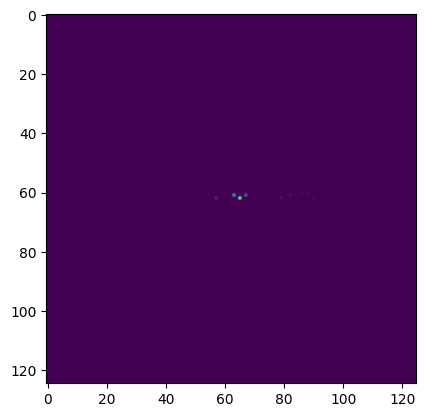

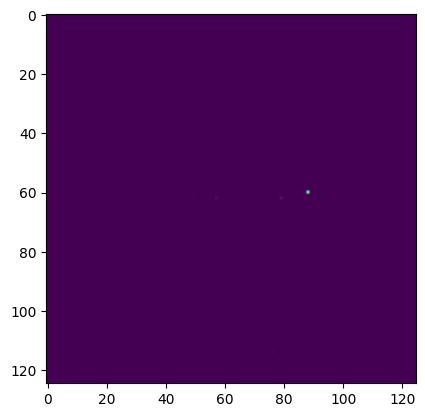

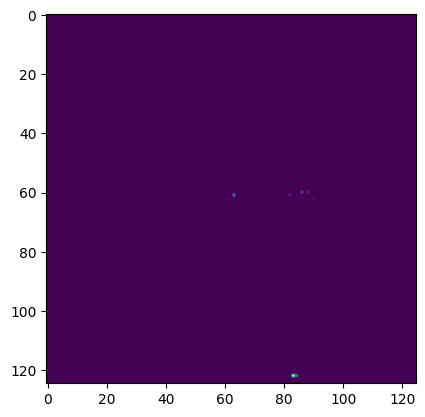

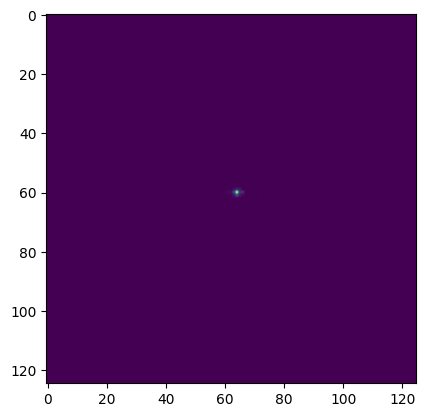

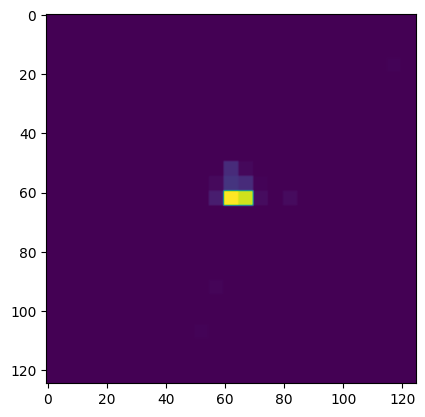

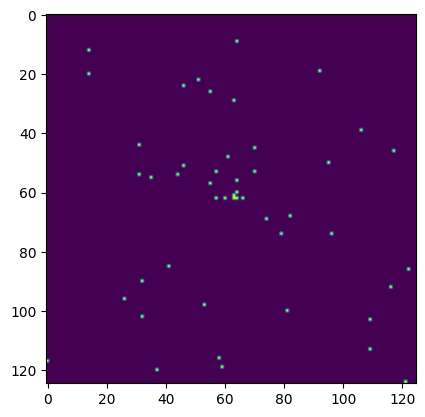

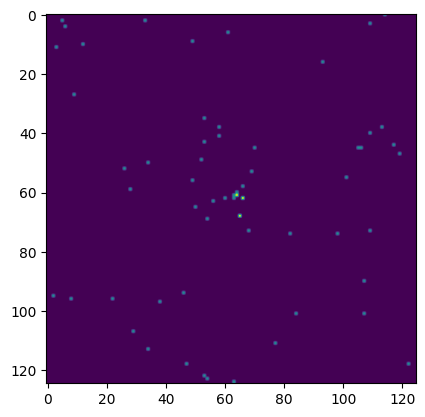

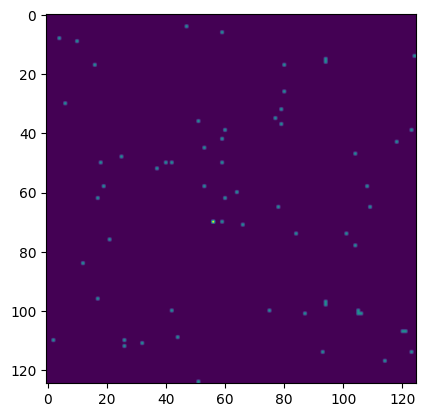

In [28]:
# !pip install torchviz
sample = val_dataset.__getitem__(0)
print((sample['img']).shape)

img = sample['img'].permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

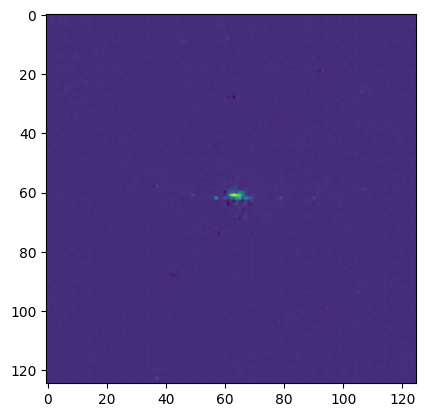

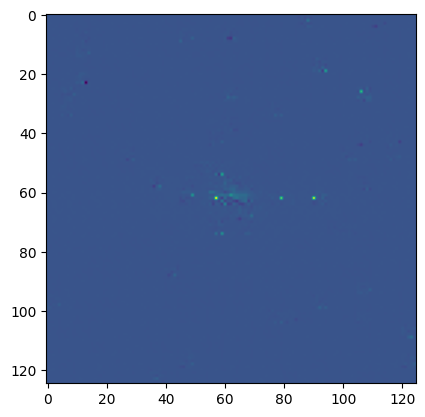

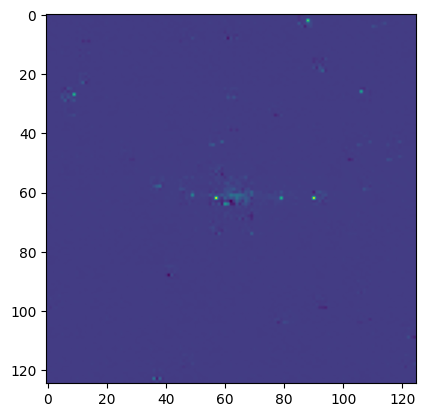

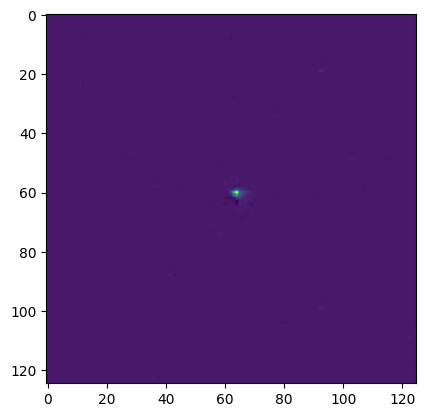

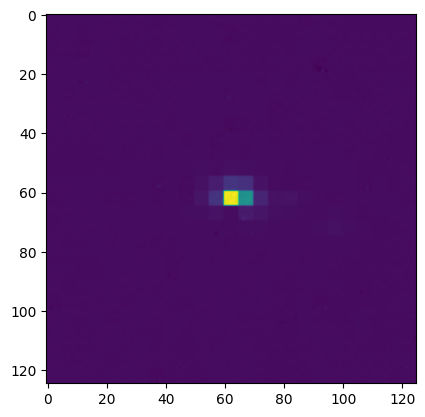

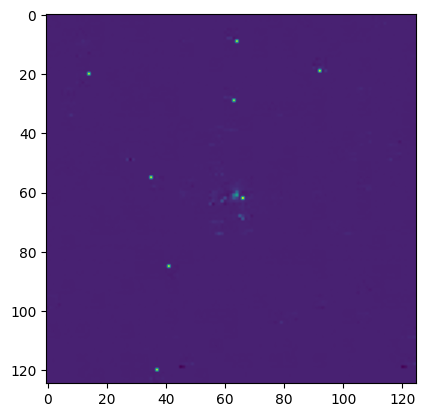

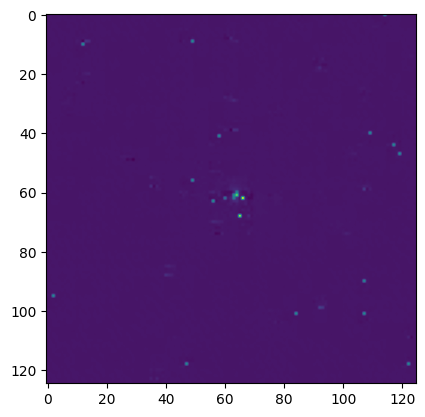

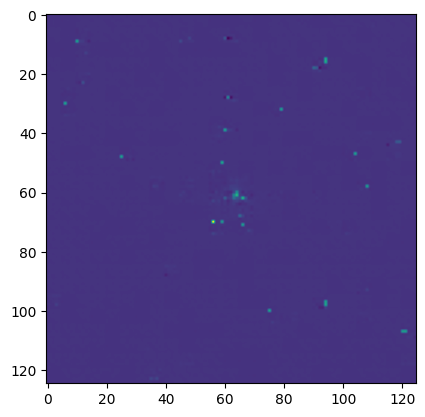

In [29]:
pred, ind, imgs = model(sample['img'].unsqueeze(0))

pred.shape

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 8, H, W)
    """
    p = 5
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
    return imgs

# pred = pred.reshape((125,125,8))
pred = unpatchify(pred)
pred.shape
pred = pred.reshape((8, 125, 125))
pred.shape

img = pred.permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

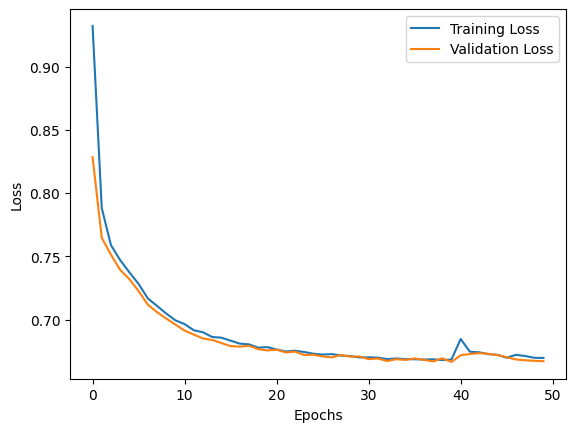

In [30]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()